In [297]:
import particle as pt
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplhep
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import time
from matplotlib.colors import LogNorm
mplhep.style.use(mplhep.style.ROOT)
from pprint import pprint
from tqdm import tqdm
import polars as pl
import sys

sys.path.append('/home/henrique/Documents/Atmos_Pandora/apc_atmo_repo/personal/Henrique/anatree_polars_ana/')
from ana_tree_class import Anatree

plt.rcParams.update({'font.size': 16,
                     'grid.linestyle': '--',
                     'axes.grid': True,
                     'figure.autolayout': True
                     })

anatree:Anatree

In [300]:
anatree = Anatree("/home/henrique/Documents/Atmos_Pandora/data/atm_50k_hd_AV_2.5_random/anatree_hd_AV_2dot5_random_sum.root")
anatree.tree:uproot.TTree

TypeError: Anatree.__init__() got an unexpected keyword argument 'entry_start'

In [ ]:
geant = pl.from_pandas(anatree.geant)
nu = pl.from_pandas(anatree.nu)
shw = pl.from_pandas(anatree.reco_showers)
tracks = pl.from_pandas(anatree.reco_tracks)

In [10]:
merged = geant.join(tracks, left_on=["subrun", "event", "TrackId_geant"], right_on=["subrun", "event", "trkg4id_pandoraTrack"], how="inner")
merged = merged.join(nu, left_on=["subrun", "event"], right_on=["subrun", "event"], how="inner")

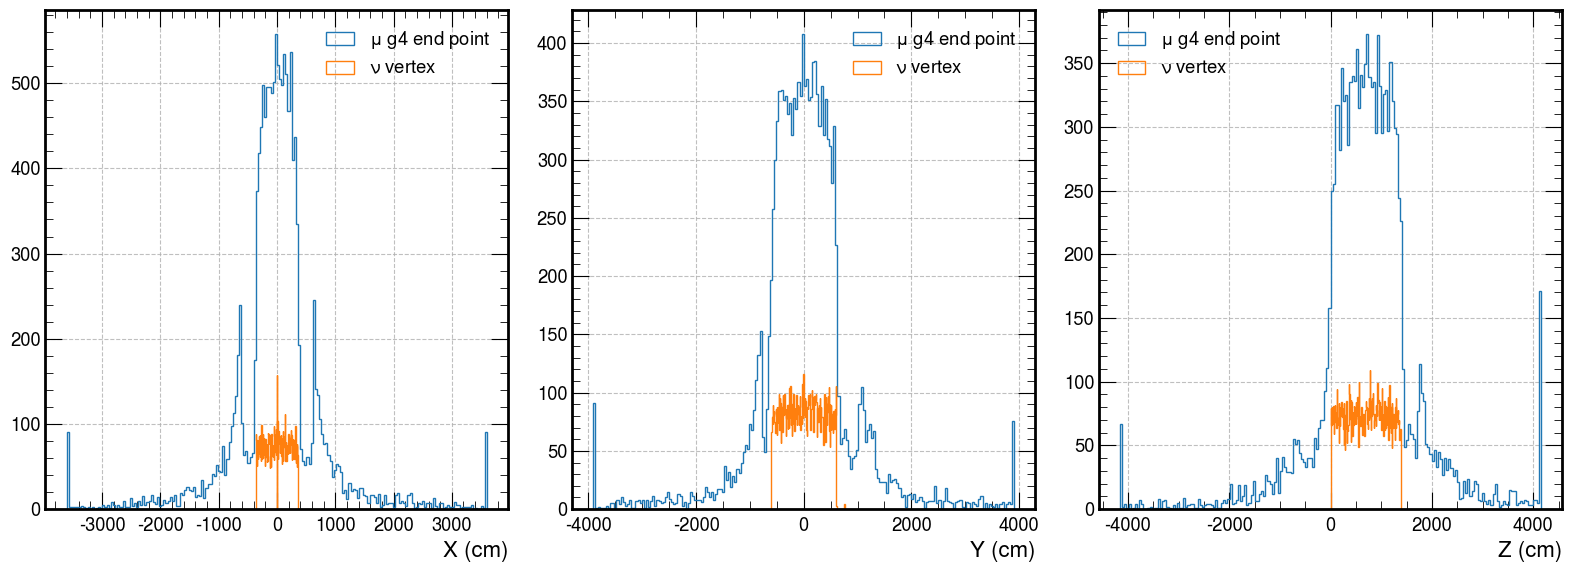

In [12]:
pl.Config.set_tbl_cols(20)
test = merged.filter(
    (pl.col('Mother_geant')==0) & (pl.col('pdg_geant').abs() == 13)
)

def make_plots(ax:plt.Axes, coord:str):
    ax.hist(test[f'EndPoint{coord}_geant'], bins = 200, histtype='step', label=rf'$\mu$ g4 end point')
    ax.hist(test[f'nuvtx{coord}'], bins = 200, histtype='step', label=rf'$\nu$ vertex')
    ax.set_xlabel(f'{coord.capitalize()} (cm)')
    ax.legend()

fig, axs = plt.subplots(1,3,figsize=(16,6))
make_plots(axs[0], 'x')
make_plots(axs[1], 'y')
make_plots(axs[2], 'z')

### Checking muons that scaped the TPC


In [49]:
# xlim = nu['nuvtxx'].abs().max()
# ylim = nu['nuvtxy'].abs().max()
# zmin = nu['nuvtxz'].min()
# zmax = nu['nuvtxz'].max()
xlim = 363.376 - 20
ylim = 607.829 - 20
zmin = -0.87625 + 20
zmax = 1393.46 - 20
print(f'{xlim} {ylim} {zmin} {zmax}')

# merged = geant.join(tracks, left_on=["subrun", "event", "TrackId_geant"], right_on=["subrun", "event", "trkg4id_pandoraTrack"], how="inner")

out_siders = test
out_siders = out_siders.groupby(["subrun", "event"]).agg(
    pl.all().sort_by('trklen_pandoraTrack').last()
)
out_siders.sort([ 'subrun','event' ])
out_siders = out_siders.filter(
    # ~(pl.col('EndPointx_geant').abs() < xlim) | ~(pl.col('EndPointy_geant').abs() < ylim) | ~( pl.col('EndPointz_geant') > zmin ) & ( pl.col('EndPointz_geant') < zmax )
    ~(pl.col('trkendx_pandoraTrack').abs() < xlim) | ~(pl.col('trkendy_pandoraTrack').abs() < ylim) | ~(( pl.col('trkendz_pandoraTrack') > zmin ) & ( pl.col('trkendz_pandoraTrack') < zmax ))
)

out_siders.sort('subrun').head(20)
out_siders.filter(
    True
    # pl.col('trkhasPFParticle_pandoraTrack') == 0
).sort('subrun')

343.376 587.829 19.12375 1373.46


subrun,event,pdg_geant,status_geant,Mass_geant,Eng_geant,EndE_geant,Px_geant,Py_geant,Pz_geant,P_geant,StartPointx_geant,StartPointy_geant,StartPointz_geant,StartT_geant,EndPointx_geant,EndPointy_geant,EndPointz_geant,EndT_geant,theta_geant,phi_geant,theta_xz_geant,theta_yz_geant,pathlen_geant,inTPCActive_geant,StartPointx_tpcAV_geant,StartPointy_tpcAV_geant,StartPointz_tpcAV_geant,StartT_tpcAV_geant,StartE_tpcAV_geant,StartP_tpcAV_geant,StartPx_tpcAV_geant,StartPy_tpcAV_geant,StartPz_tpcAV_geant,EndPointx_tpcAV_geant,EndPointy_tpcAV_geant,EndPointz_tpcAV_geant,EndT_tpcAV_geant,EndE_tpcAV_geant,EndP_tpcAV_geant,EndPx_tpcAV_geant,EndPy_tpcAV_geant,EndPz_tpcAV_geant,pathlen_drifted_geant,inTPCDrifted_geant,StartPointx_drifted_geant,StartPointy_drifted_geant,StartPointz_drifted_geant,StartT_drifted_geant,StartE_drifted_geant,…,trkthetayz_pandoraTrack,trkmom_pandoraTrack,trkmomrange_pandoraTrack,trkmommschi2_pandoraTrack,trkmommsllhd_pandoraTrack,trklen_pandoraTrack,trksvtxid_pandoraTrack,trkevtxid_pandoraTrack,trkpidmvamu_pandoraTrack,trkpidmvae_pandoraTrack,trkpidmvapich_pandoraTrack,trkpidmvaphoton_pandoraTrack,trkpidmvapr_pandoraTrack,trkpidndf_pandoraTrack_x,trkpidndf_pandoraTrack_y,trkpidndf_pandoraTrack_z,trkpidchi_pandoraTrack_x,trkpidchi_pandoraTrack_y,trkpidchi_pandoraTrack_z,trkpidchipr_pandoraTrack_x,trkpidchipr_pandoraTrack_y,trkpidchipr_pandoraTrack_z,trkpidchika_pandoraTrack_x,trkpidchika_pandoraTrack_y,trkpidchika_pandoraTrack_z,trkpidchipi_pandoraTrack_x,trkpidchipi_pandoraTrack_y,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack,nuPDG_truth,ccnc_truth,nuvtxx_truth,nuvtxy_truth,nuvtxz_truth,enu_truth,nu_dcosx_truth,nu_dcosy_truth,nu_dcosz_truth,mode_truth,nuvtxx,nuvtxy,nuvtxz
i32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,i16,i16,f32,f32,f32,f32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16,i32,i32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32
0,9,13,1,0.105658,4.463607,0.105658,0.98235,2.559539,-3.520849,4.462357,-4.658782,-603.170349,1222.501587,0.0,319.632996,328.466949,-221.026978,59.240833,2.479994,1.204333,2.869503,2.512997,1484.515625,1,-4.658782,-603.170349,1222.501587,0.0,4.463607,4.462357,0.98235,2.559539,-3.520849,278.194702,196.543488,5.689342,49.61932,0.694594,0.686511,0.100115,0.343684,-0.585794,1484.51709,1,-4.658782,-603.170349,1222.501587,0.0,4.463607,…,2.546078,1.0,3.578407,-99999.0,-99999.0,1443.608398,-1,-1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,54,21,45,-99999.0,-99999.0,-99999.0,234.379089,217.688904,212.598969,88.46743,85.084969,90.287094,12.403071,12.952723,14.809963,7.680189,6.577821,8.413167,6.182122,6.352591,5.847925,0,1,0,14,0,-4.658782,-603.170349,1222.501587,5.01884,0.29367,0.576258,-0.762688,1,4.910364,-576.209412,1185.788208
0,15,13,1,0.105658,0.466599,0.105658,0.365897,-0.088116,0.254765,0.454478,-362.027527,-598.956543,1087.422363,0.0,-237.972977,-619.322205,1169.43042,5.672615,0.975727,-0.236321,0.962575,-0.332991,52.269238,1,-362.027527,-598.956543,1087.422363,0.0,0.466599,0.454478,0.365897,-0.088116,0.254765,-320.447021,-607.1828,1117.980713,1.804507,0.359126,0.343231,0.27249,-0.040985,0.204639,52.26947,1,-362.027527,-598.956543,1087.422363,0.0,0.466599,…,-0.295489,1.0,0.09355,-99999.0,-99999.0,6.229081,-1,-1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,9,9,5,-99999.0,-99999.0,-99999.0,276.141663,306.500702,269.02356,161.334824,145.344284,128.87886,52.68261,37.625755,33.232979,35.935326,25.707708,21.491894,1.038233,2.099389,2.451885,0,1,0,14,0,-362.027527,-598.956543,1087.422363,1.03482,-0.923,-0.017455,0.384419,0,-361.977875

In [50]:
tmp = out_siders.select(
    pl.col('subrun'),
    pl.col('event'),
    pl.col('Eng_geant'),
    pl.col('EndPointx_geant'),
    pl.col('EndPointy_geant'),
    pl.col('EndPointz_geant'),
    # pl.col('trkg4id_pandoraTrack'),
    pl.col('trklen_pandoraTrack'),
    # pl.col('trkstartx_pandoraTrack'),
    # pl.col('trkstarty_pandoraTrack'),
    # pl.col('trkstartz_pandoraTrack'),
    pl.col('trkendx_pandoraTrack'),
    pl.col('trkendy_pandoraTrack'),
    pl.col('trkendz_pandoraTrack'),
    pl.col('trkPFParticleID_pandoraTrack')
).filter(
    True
    # (pl.col('event')==9) & (pl.col('subrun')==0)
).sort('subrun')
tmp.head(15)


# tracks.select(
#     pl.col('subrun'),
#     pl.col('event'),
#     pl.col('trkstartx_pandoraTrack'),
#     pl.col('trkstarty_pandoraTrack'),
#     pl.col('trkstartz_pandoraTrack'),
#     pl.col('trkendx_pandoraTrack'),
#     pl.col('trkendy_pandoraTrack'),
#     pl.col('trkendz_pandoraTrack')
# ).filter(
#     (pl.col('event')==9) & (pl.col('subrun')==0)
# )

subrun,event,Eng_geant,EndPointx_geant,EndPointy_geant,EndPointz_geant,trklen_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,trkPFParticleID_pandoraTrack
i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,i16
0,9,4.463607,319.632996,328.466949,-221.026978,1443.608398,278.704956,199.624405,0.566093,0
0,15,0.466599,-237.972977,-619.322205,1169.43042,6.229081,-357.230743,-599.958679,1090.517456,0
1,2,0.878233,-649.772156,-754.243713,1073.46521,18.246937,-83.896805,-599.95105,950.137512,1
1,7,1.480516,-787.385437,262.271637,799.142029,73.830688,-362.117828,535.164551,783.006714,0
1,16,1.038014,-649.562012,-92.057983,-101.60038,181.986298,-362.477783,63.690903,335.441193,0
2,5,0.276977,337.096252,-485.976166,851.583862,60.98296,355.935394,-431.340668,826.542969,0
3,3,8.554273,1276.314209,-386.399292,2204.376709,1014.14563,362.14267,-249.398453,1191.071899,0
3,18,0.20288,-345.696381,168.215881,1028.313965,28.053375,-345.443207,167.878983,1028.722656,0
3,10,0.825537,616.872253,801.615784,313.679626,160.88472,257.278137,599.941406,101.561409,0


In [ ]:
subsample = merged.select(
    pl.col(["subrun", "event"]),
    pl.col("TrackId_geant"),
    pl.col("pdg_geant"),
    pl.col("^trk.*$"),
).select(
    # pl.all()
    pl.exclude("^*cosmic.*$")
)

sample_with_PFP = subsample.filter(
    pl.col("trkhasPFParticle_pandoraTrack")!=0
)
sample_without_PFP = subsample.filter(
    pl.col("trkhasPFParticle_pandoraTrack")==0
)

subsample.groupby([ 'subrun' , 'event']).agg(
    pl.all()
).sort(['subrun','event'])

# sample_without_PFP.groupby([ 'subrun' , 'event']).agg(
#     pl.all()
# ).sort(['subrun','event'])

# sample_without_PFP.groupby('subrun').agg(
#     pl.all()
# )

subrun,event,TrackId_geant,pdg_geant,trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,…,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack
i32,i32,list[i32],list[i32],list[i16],list[f32],list[f32],list[f32],list[f32],list[f32],…,list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[f32],list[i16],list[i16],list[i16]
0,1,"[5, 178, 320]","[2212, 2212, 22]","[1, 2, 0]","[136.64624, 11.924668, 129.836563]","[103.644913, -99999.0, 110.626808]","[139.777359, 97.965752, 491.586517]","[15.079591, 3.274446, 39.346676]","[14.20891, -99999.0, 39.117794]",…,"[63.702892, 55.79911, 75.537567]","[47.364105, 12.96113, 30.742678]","[31.830832, -99999.0, 31.406918]","[59.164288, 22.388433, 44.366299]","[17.744862, 3.093564, 1.759832]","[16.381996, -99999.0, 2.181928]","[19.042437, 3.336291, 0.868701]","[0, 2, 0]","[1, 0, 0]","[1, -1, -1]"
0,2,"[2, 2]","[11, 11]","[0, 1]","[53.395184, 8.951428]","[129.895081, 3.680822]","[98.96701, -99999.0]","[11.616394, 3.709249]","[16.429333, 2.410001]",…,"[14.335725, -99999.0]","[12.218629, 15.856066]","[35.474968, -99999.0]","[13.100616, -99999.0]","[4.647438, 2.646887]","[4.622357, -99999.0]","[7.516234, -99999.0]","[2, 0]","[0, 1]","[-1, 1]"
0,4,"[4, 287, 559]","[2212, 2212, 2212]","[2, 0, 1]","[66.608459, 463.107666, 41.658722]","[-99999.0, 471.538269, 79.96769]","[86.85836, 477.121704, 42.096596]","[5.70126, 109.040665, 15.116651]","[-99999.0, 109.936317, 17.100664]",…,"[22.646267, 10.005317, 5.717801]","[40.397869, 6.839103, 5.093225]","[-99999.0, 8.615121, 18.015244]","[25.345932, 8.888405, 3.439317]","[16.086803, 10.935943, 6.250153]","[-99999.0, 9.97599, 5.974052]","[14.037346, 9.619142, 6.504714]","[0, 1, 0]","[1, 1, 1]","[2, 0, 1]"
0,5,"[1, 3, … 70]","[13, 2212, … 22]","[0, 3, … 1]","[107.680252, 55.232586, … 48.635715]","[94.48278, 61.773464, … 57.215668]","[100.041451, 85.321022, … 26.978184]","[26.238886, 5.850797, … 9.83387]","[22.673147, 3.73948, … 9.586802]",…,"[2.952304, 36.391033, … 42.428505]","[1.343927, 19.916954, … 33.164371]","[3.968472, 25.168539, … 38.116367]","[1.892629, 37.560627, … 27.825895]","[8.072895, 3.925165, … 2.305274]","[8.579092, 1.052197, … 0.619294]","[7.621387, 18.335388, … 1.549049]","[0, 0, … 1]","[1, 1, … 0]","[0, 3, … -1]"
0,6,"[2, 3]","[-13, 2212]","[0, 1]","[802.204285, -99999.0]","[466.48938, 298.121887]","[462.267944, 443.672607]","[198.926422, -99999.0]","[192.945053, 28.213326]",…,"[2.951583, 41.497654]","[8.399777, -99999.0]","[3.574767, 46.144169]","[1.837219, 44.886852]","[8.517381, -99999.0]","[8.234681, 18.624382]","[7.964117, 18.212143]","[0, 2]","[1, 1]","[0, 1]"
0,7,[4],[22],[0],[4.163157],[3.298256],[6.377603],[2.135132],[0.106504],…,[42.642143],[31.115345],[35.2897],[37.120766],[1.129639],[0.647177],[1.070502],[0],[0],[-1]
0,8,"[1, 4, … 10619]","[11, -211, … 2212]","[1, 3, … 4]","[45.457039, 25.700741, … 29.233528]","[340.512299, -99999.0, … -99999.0]","[-99999.0, 101.062141, … 69.597588]","[9.900106, 17.934486, … 24.901514]","[18.473347, -99999.0, … -99999.0]",…,"[-99999.0, 13.172743, … 7.315737]","[19.107826, 36.240276, … 27.19812]","[30.767391, -99999.0, … -99999.0]","[-99999.0, 11.365609, … 4.562796]","[2.813972, 2.640562, … 3.055145]","[10.058064, -99999.0, … -99999.0]","[-99999.0, 6.289466, … 6.569714]","[1, 2, … 2]","[0, 1, … 1]","[-1, 3, … 4]"
0,9,"[1, 1, 1]","[13, 13, 13]","[0, 1, 2]","[3477.580078, 29.119215, -99999.0]","[3362.11084, 44.909351, 40.384235]","[3392.647705, -99999.0, 29.522285]","[1443.206543, 7.129018, -99999.0]","[1442.735107, 7.845863, 14.237829]",…,"[14.809963, -99999.0, 48.082878]","[7.680189, 12.822991, -99999.0]","[6.577821, 31.111084, 23.262844]","[8.413167, -99999.0, 28.948536]","[6.182122, 3.485022, -9999

trkId_pandoraTrack,trkke_pandoraTrack_x,trkke_pandoraTrack_y,trkke_pandoraTrack_z,trkrange_pandoraTrack_x,trkrange_pandoraTrack_y,trkrange_pandoraTrack_z,trkidtruth_pandoraTrack_x,trkidtruth_pandoraTrack_y,trkidtruth_pandoraTrack_z,trkorigin_pandoraTrack_x,trkorigin_pandoraTrack_y,trkorigin_pandoraTrack_z,trkpdgtruth_pandoraTrack_x,trkpdgtruth_pandoraTrack_y,trkpdgtruth_pandoraTrack_z,trkefftruth_pandoraTrack_x,trkefftruth_pandoraTrack_y,trkefftruth_pandoraTrack_z,trkpurtruth_pandoraTrack_x,trkpurtruth_pandoraTrack_y,trkpurtruth_pandoraTrack_z,trkpitchc_pandoraTrack_x,trkpitchc_pandoraTrack_y,trkpitchc_pandoraTrack_z,trkstartx_pandoraTrack,trkstarty_pandoraTrack,trkstartz_pandoraTrack,trkstartd_pandoraTrack,trkendx_pandoraTrack,trkendy_pandoraTrack,trkendz_pandoraTrack,trkendd_pandoraTrack,trkflashT0_pandoraTrack,trktrueT0_pandoraTrack,trkg4id_pandoraTrack,trkorig_pandoraTrack,trkpurity_pandoraTrack,trkcompleteness_pandoraTrack,trktheta_pandoraTrack,trkphi_pandoraTrack,trkstartdcosx_pandoraTrack,trkstartdcosy_pandoraTrack,trkstartdcosz_pandoraTrack,trkenddcosx_pandoraTrack,trkenddcosy_pandoraTrack,trkenddcosz_pandoraTrack,trkthetaxz_pandoraTrack,trkthetayz_pandoraTrack,trkmom_pandoraTrack,trkmomrange_pandoraTrack,trkmommschi2_pandoraTrack,trkmommsllhd_pandoraTrack,trklen_pandoraTrack,trksvtxid_pandoraTrack,trkevtxid_pandoraTrack,trkpidmvamu_pandoraTrack,trkpidmvae_pandoraTrack,trkpidmvapich_pandoraTrack,trkpidmvaphoton_pandoraTrack,trkpidmvapr_pandoraTrack,trkpidndf_pandoraTrack_x,trkpidndf_pandoraTrack_y,trkpidndf_pandoraTrack_z,trkpidchi_pandoraTrack_x,trkpidchi_pandoraTrack_y,trkpidchi_pandoraTrack_z,trkpidchipr_pandoraTrack_x,trkpidchipr_pandoraTrack_y,trkpidchipr_pandoraTrack_z,trkpidchika_pandoraTrack_x,trkpidchika_pandoraTrack_y,trkpidchika_pandoraTrack_z,trkpidchipi_pandoraTrack_x,trkpidchipi_pandoraTrack_y,trkpidchipi_pandoraTrack_z,trkpidchimu_pandoraTrack_x,trkpidchimu_pandoraTrack_y,trkpidchimu_pandoraTrack_z,trkpidpida_pandoraTrack_x,trkpidpida_pandoraTrack_y,trkpidpida_pandoraTrack_z,trkpidbestplane_pandoraTrack,trkhasPFParticle_pandoraTrack,trkPFParticleID_pandoraTrack
i16,f32,f32,f32,f32,f32,f32,i32,i32,i32,i16,i16,i16,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,f32,f32,f32,f32,f32,i32,i32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i16,i16,i16
0,1476.505859,1362.933228,1683.381348,798.527405,797.377136,798.670837,1,1,1,1,1,1,-13,-13,-13,0.82932,0.669581,0.897384,0.991805,0.984413,0.992147,0.604862,2.619869,0.818714,155.92749,334.692078,462.401917,207.448563,-282.336212,-214.59436,85.35984,81.039841,-99999.0,-99999.0,1,1,0.989856,0.999999,2.036962,-2.211315,-0.533845,-0.716234,-0.449464,-0.632076,-0.508588,-0.584652,-2.270591,-2.131219,1.0,1.950854,-99999.0,-99999.0,798.898682,-1,-1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,43,20,31,-99999.0,-99999.0,-99999.0,97.031937,296.324036,97.213158,29.140703,160.041824,32.741829,3.707146,41.884323,2.353055,4.277405,30.71287,2.46693,8.585032,2.21278,8.214401,0,1,0
0,1.2417e9,2.1737e6,2.6077276e7,363.065247,355.107483,253.958633,2,2,2,1,1,1,11,11,11,0.609189,0.570542,0.348993,0.898036,0.891477,0.98277,44.986835,0.490682,0.565118,24.891899,-137.860367,314.104523,314.980774,-123.363625,-62.594353,454.860352,240.012421,-99999.0,-99999.0,2,1,0.913508,0.663353,0.891681,2.583776,-0.660175,0.411891,0.628105,0.00448,-0.805875,0.592069,-0.810286,0.580419,1.0,1.005604,-99999.0,-99999.0,400.089264,-1,-1,-99999.0,-99999.0,-99999.0,-99999.0,-99999.0,2,3,3,-99999.0,-99999.0,-99999.0,423.0513,159.106766,246.239471,399.036713,88.730614,78.258636,80.202454,15.867043,34.401455,50.068401,8.917578,25.362474,0.87089,5.390366,4.357722,0,0,-1
2,136.023407,233.759064,220.873581,109.349487,123.521263,124.099213,7,7,7,1,1,1,-211,-211,-211,0.543468,0.838449,0.976187,0.855771,0.838472,0.845584,0.660862,0.615669,0.525516,27.410936,-141.0832

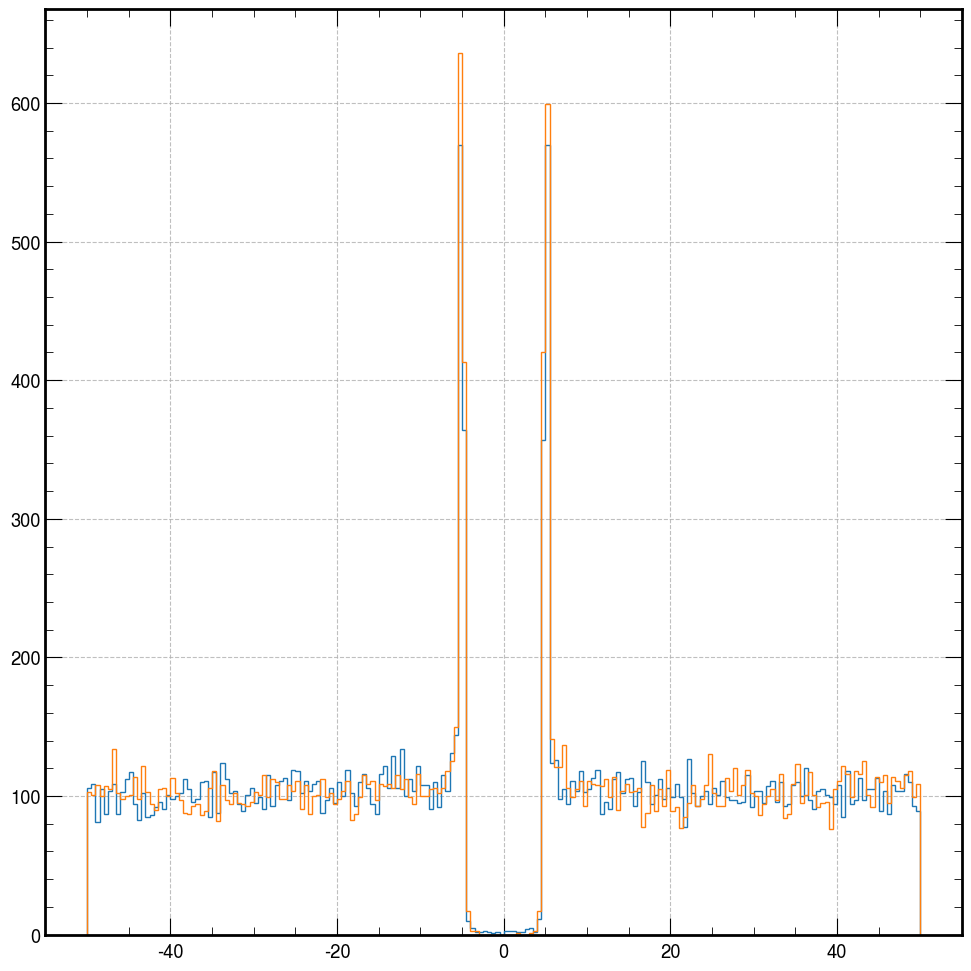

In [42]:
plt.hist(tracks['trkendx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
plt.hist(tracks['trkstartx_pandoraTrack'], bins=200, range=(-50,50), histtype='step');
# pl.Config.set_tbl_cols(100)
tracks.filter(
    (pl.col('trkendx_pandoraTrack')*pl.col('trkstartx_pandoraTrack') < 0) 
).select(
    pl.col('^trk.*$')
).select(
    pl.exclude("^*cosmic.*$")
)



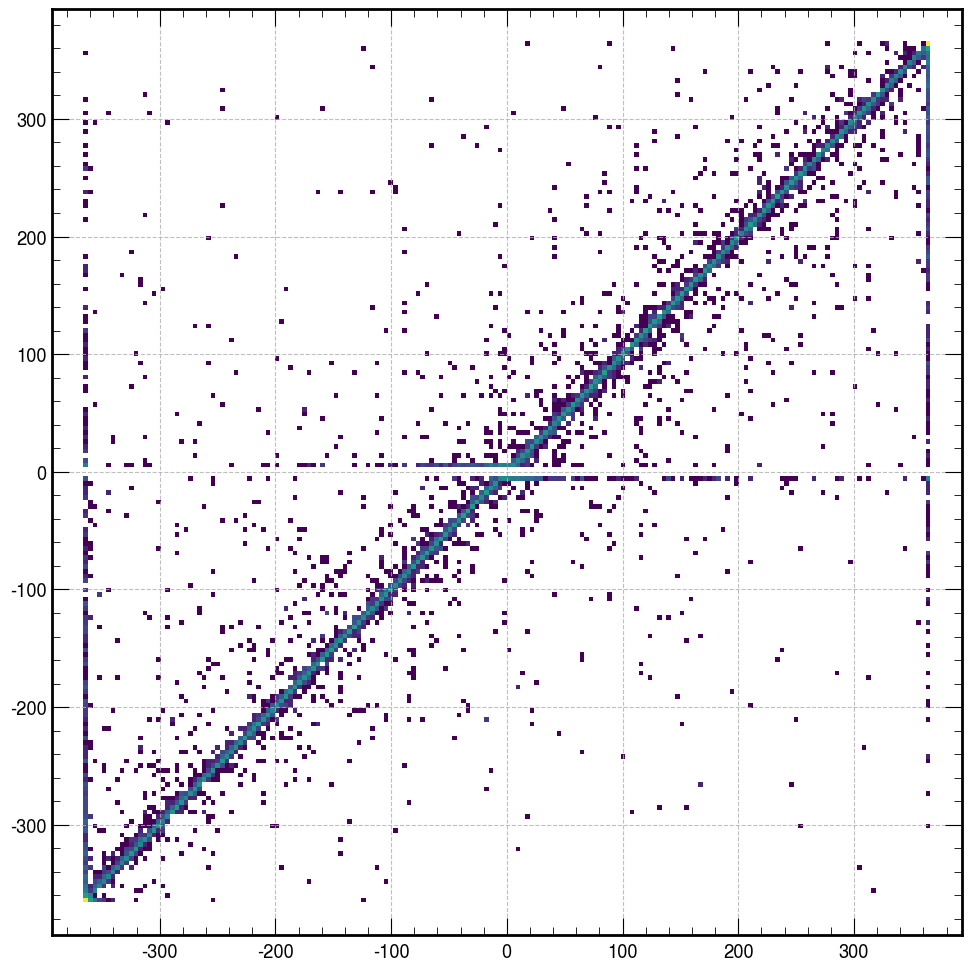

In [90]:

tmp = merged.filter(
    (pl.col('pdg_geant').abs() == 13) & (pl.col('Mother_geant')== 0),
).filter(
    ( pl.col('trkhasPFParticle_pandoraTrack') == 1 )

)
plotlim = xlim+50
plt.hist2d(tmp['EndPointx_drifted_geant'], tmp['trkendx_pandoraTrack'], bins=(200,200), range=((-plotlim,plotlim),(-plotlim,plotlim)), norm=LogNorm());


In [295]:
anatree.tree["EndE_drifted_geant"]
cols = [key for key in anatree.tree.keys() if 'trk' in key] 
# cols.remove("no_primaries_geant")
# cols.remove("geant_list_size_geant")
# cols.remove("geant_list_size_in_tpcAV_geant")
cols
test = [col.name for col in tracks.mean().select(pl.all().max() < -99) if col.item()]

exclusion_list = ['cosmic', 'T0', 'momms', 'pidmva', 'evtxid']  #all this are empty
# cols = [x for x in cols if any(exclusion_item not in x for exclusion_item in exclusion_list)]
cols
# cols = set(cols)
# test = set(test)
cols

# test
# tracks.mean().select(
#     pl.all().max() > 0
# )

# [col.item() for col in tracks.select(pl.all().max()<0)]

['trkId_pandoraTrack',
 'trkncosmictags_tagger_pandoraTrack',
 'trkcosmicscore_tagger_pandoraTrack',
 'trkcosmictype_tagger_pandoraTrack',
 'trkncosmictags_containmenttagger_pandoraTrack',
 'trkcosmicscore_containmenttagger_pandoraTrack',
 'trkcosmictype_containmenttagger_pandoraTrack',
 'trkncosmictags_flashmatch_pandoraTrack',
 'trkcosmicscore_flashmatch_pandoraTrack',
 'trkcosmictype_flashmatch_pandoraTrack',
 'trkke_pandoraTrack',
 'trkrange_pandoraTrack',
 'trkidtruth_pandoraTrack',
 'trkorigin_pandoraTrack',
 'trkpdgtruth_pandoraTrack',
 'trkefftruth_pandoraTrack',
 'trkpurtruth_pandoraTrack',
 'trkpitchc_pandoraTrack',
 'ntrkhits_pandoraTrack',
 'trkdedx_pandoraTrack',
 'trkdqdx_pandoraTrack',
 'trkresrg_pandoraTrack',
 'trktpc_pandoraTrack',
 'trkxyz_pandoraTrack',
 'trkstartx_pandoraTrack',
 'trkstarty_pandoraTrack',
 'trkstartz_pandoraTrack',
 'trkstartd_pandoraTrack',
 'trkendx_pandoraTrack',
 'trkendy_pandoraTrack',
 'trkendz_pandoraTrack',
 'trkendd_pandoraTrack',
 'trkfla

statistic,value
str,f64
"""count""",141758.0
"""null_count""",0.0
"""mean""",-11457.105466
"""std""",31886.244088
"""min""",-99999.0
"""max""",147.540649
"""median""",21.814719
"""25%""",8.259665
"""75%""",35.277622
